# **Set Up**

Handle imports and initialize a few directory paths

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2,keras
import json
import math
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50#, preprocess_input
import numpy as np
import tensorflow as tf
import keras.layers as KL
import keras.backend as K
from keras.utils import Sequence
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Set random seeds
seed = 232
np.random.seed(seed)
#tf.set_random_seed(seed)

#set image inputs
dataset_path = '/kaggle/input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/'
trainingImageDirPath = '/kaggle/input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/train_images/'
trainingAnnotationsPath = '/kaggle/input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/train_annotations.json'
testingImageDirPath = '/kaggle/input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/val_images/'
#trainingAnnotationsPath = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv'


**Demo**

Check out some xrays

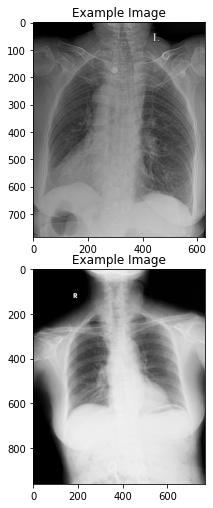

In [3]:
#Plot some examples
fig, ax = plt.subplots(2, 1, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train_images/', 'val_images/']):
    set_path = dataset_path+_set
    ax[i].imshow(plt.imread(set_path+os.listdir(set_path)[0]), cmap='gray')
    ax[i].set_title('Example Image'.format(_set))

**HELPER FUNCTIONS**

**Build Constants**

Initialize some constants

In [41]:
#RCNN Constants
#We will only use square images, what is the n in nxn?
N_RPN_TRAIN_IMAGE_SIZE = 512
N_INPUT_CHANNELS = 3

RPN_INPUT_SHAPE = (N_RPN_TRAIN_IMAGE_SIZE, N_RPN_TRAIN_IMAGE_SIZE, N_INPUT_CHANNELS)
ANCHOR_STRIDE = 5
ANCHOR_SCALES = (32, 64, 128, 256, 512)
ANCHORS_PER_LOCATION = len(ANCHOR_SCALES)^2
N_FEATURE_MAP_SIZE = 62
ANCHOR_IOU_FG_THRESHOLD = 0.6
ANCHOR_IOU_BG_THRESHOLD = 0.1

#This constant must be hand written to match the AlexNet
FEATURE_MAP_SHAPE = (1, N_FEATURE_MAP_SIZE, N_FEATURE_MAP_SIZE, 256)

LEARNING_RATE = 0.001
LEARNING_MOMENTUM = 0.9
BATCH_SIZE = 8
EPOCHS = 10

**Compute IOU Data**

Compute the IOU data of two rectangles. The IOU of two rectangles is the ratio of how much of the rectangles overlap to the amount that the rectangles don't overlap, measured in 2-D area.

In [5]:
def computeIouList(rect1, rect2List):
    rect1area= (rect1[2] - rect1[0]) * (rect1[3] - rect1[1])
    rect2area = (rect2List[:, 2] - rect2List[:, 0]) * (rect2List[:, 3] - rect2List[:, 1]) # area = width * height
    
    #Get X, y coordinates of intersecting rectangle
    xMin = np.maximum(rect1[0], rect2List[:, 0])
    yMin = np.maximum(rect1[1], rect2List[:, 1])
    xMax = np.minimum(rect1[2], rect2List[:, 2])
    yMax = np.minimum(rect1[3], rect2List[:, 3])
    
    #get area of intersecting rectangle
    intersection = np.maximum(0, xMax - xMin + 1) * np.maximum(0, yMax - yMin + 1)
    union = rect1area + rect2area[:] - intersection[:]
    iou = intersection / union
    
    return iou

**Get Images From Rect Data**

It is important that all of our regions are squares, so that they are compatible with the neural network that we build. For this reason we must resize all the images we pull in by a constant value.

In [6]:
#Perform Preprocessing on Rect Proposals
def GetRectImageData(rects, image):
    props = []
    
    (x, y, x2, y2) = rects
    (x, y, x2, y2) = (int(x), int(y), int(x2), int(y2))
        
    #extract rect from image
    rect = image[y:x2, x:y2]
    #convert color
    RGBrect = cv2.cvtColor(rect, cv2.COLOR_BGR2RGB)
    #Resize rects to NxN
    squareRect = cv2.resize(RGBrect, (N_REGION_RPN_TRAIN_IMAGE_SIZE, N_REGION_RPN_TRAIN_IMAGE_SIZE))
        
    return squareRect
        

**Generate Anchors**

Given a feature map, we want to generate some anchors. We will use the constants for image size and anchor stride for this calculation. The challenge is that we are trying to generate evenly spaced anchor points in a full size image using a feature map. Most of this function consists of generating every possible combination of box shape and size, then spacing them out evenly throughout the possible range of values in the image.

In [7]:
def GetAnchors(featureMapNSide):
    featureStrides = int(N_RPN_TRAIN_IMAGE_SIZE/featureMapNSide) # 512/13 ~= 39

    # All combinations of anchor points
    #ex: Range from 0 to 13 with a stride of 1
    # (0,2,3,6,...10,12) * 39 = (0, 39, 78, 117 ... 507)
    start = int(ANCHOR_STRIDE/2)
    end = int(N_RPN_TRAIN_IMAGE_SIZE - start* featureStrides)
    print(end)
    
    x = np.arange(start*featureStrides, end, ANCHOR_STRIDE * featureStrides)
    y = np.arange(start*featureStrides, end, ANCHOR_STRIDE * featureStrides)
    x, y = np.meshgrid(x, y)  #shapes: 39x39
    
    #print(x)
    #print(x[0][5])

    # All combinations of indices, and shapes
    anchorBBoxes = []
    scale = len(x)
    for idy in range(scale):
        for idx in range(scale):
            for width in ANCHOR_SCALES:
                for height in ANCHOR_SCALES:
                    BBox = (x[idy][idx] - width/2, y[idy][idx] - height/2, x[idy][idx] + width/2, y[idy][idx] + height/2)
                    anchorBBoxes.append(BBox)

    # Anchors are created for each feature map
    #print('Num of generated anchors:\t',len(anchorBBoxes))
    anchors = np.reshape(anchorBBoxes, (scale, scale, len(ANCHOR_SCALES), len(ANCHOR_SCALES), 4))
    return anchors

**Calculate Anchor Ground Truth Data**

We need to get the indicies, the deltas of the boxes, and the labels for the ground truth data. Many things happen in this function. The first thing that happens is that we load the deltas for the boxes from the ground truth, then we find the IOUs of the boxes from the ground truth. If the IOU is above a certain amount, we label that anchor as foreground, and save it to an array which will get sent to the neural network.

In [8]:

#Make sure BBoxes is a np.array before adding
#This won't be implemented with batching
def CalculateDeltasAndLabels(BBoxes, anchors):  
    #Get anchors in 1-d Array
    linearAnchors = np.ndarray.flatten(anchors)
    anchorCount = (anchors.shape[0] * anchors.shape[1] * anchors.shape[2] * anchors.shape[3])
    boxCount = len(BBoxes)
    
    fgAnchors = []
    bgAnchors = []
    
    deltasOut = np.zeros((anchorCount, 4))
    bboxIous = np.zeros((boxCount,anchorCount)) #Intersection over union score for each bbox-anchor pair
    bboxDeltas = np.zeros((boxCount,anchorCount, 4)) #desired delta x,y,h,w for each bbox-anchor pair --> RPN shoult predict these
    
    #For each box, calculate the boxes, distance from each anchor
    for bboxnum, bbox in enumerate(BBoxes):
        #Calculate Bounding Box Deltas
        AnchorsArray = np.reshape(anchors, (anchorCount,4))
        aw = AnchorsArray[:,2] - AnchorsArray[:,0]
        ah = AnchorsArray[:,3] - AnchorsArray[:,1]
        acx = AnchorsArray[:,0] + aw[:]/2
        acy = AnchorsArray[:,1] + ah[:]/2
        
        (bbw, bbh) = (bbox[2] - bbox[0], bbox[3] - bbox[1])
        (bcx, bcy) = (bbox[0] + bbw/2, bbox[1] - bbh/2)
        
        deltasGroup = (bbw - aw[:], bbh - ah[:], bcx - acx[:], bcy - acy[:])
        
        bboxDeltas[bboxnum] = list(zip(*deltasGroup))
        #Calculate IOU
        bboxIous[bboxnum] = computeIouList(bbox, AnchorsArray)

    #For each anchor, find the nearest BBox and the IOU
    for anchor in range(anchorCount):
        bestBboxix = np.argmax(bboxIous[:,anchor])
        deltasOut[anchor] = bboxDeltas[bestBboxix, anchor]  
        iou = bboxIous[bestBboxix, anchor]
        
        if iou > ANCHOR_IOU_FG_THRESHOLD:
            fgAnchors.append([0,anchor])
            
        elif iou < ANCHOR_IOU_BG_THRESHOLD:
            bgAnchors.append([0,anchor])
            
    if fgAnchors == []:
        fgAnchors = np.array([[-1,-1]])
    if bgAnchors == []:
        bgAnchors = np.array([[-1,-1]])
    
    return  np.array(fgAnchors), np.array(bgAnchors), deltasOut

# **TRAIN THE NETWORK**

***Data Pre-processing***

We want to load the imageURLS and bounding boxe data for every photo in the directory. We can do this because it won't take too much memory but we should not load any images except in a fit generator for the model.

In [9]:
#load images into Local memory
trainingImagePaths = os.listdir(trainingImageDirPath)

index = 0
imgDirSize = len(trainingImagePaths)

annotationsFile = open(trainingAnnotationsPath)
trainingMetadata = json.load(annotationsFile)

dataCollection = []
for imgPath in trainingImagePaths:
    matchedImageMetadata = None
    
    #GET IMAGE METADATA
    for imageMetadata in trainingMetadata['images']:
        if imageMetadata['file_name'] == str("train_images/" + imgPath):
            matchedImageMetadata = imageMetadata
            break
    
    #GET ANNOTATIONS FOR IMAGE
    BBoxesDims = []
    for annotationsData in trainingMetadata['annotations']:
        if (annotationsData['image_id'] != matchedImageMetadata['id']):
            continue
            
        bboxDims = annotationsData["bbox"]
        bboxDims[2] = bboxDims[0] +  bboxDims[2]
        bboxDims[3] = bboxDims[1] +  bboxDims[3]
        BBoxesDims.append(bboxDims)
        
    dataCollection.append({"imgPath":imgPath,"bboxesDims":BBoxesDims})#"img": img,"bboxesDims": BBoxesDims})
    
    if (math.remainder(index,250) == 0):
        print("Progress: " + str(index) + " out of " + str(imgDirSize) + " images processed")
    index += 1

print("Done Loading")
#loop over images

Progress: 0 out of 3296 images processed
Progress: 250 out of 3296 images processed
Progress: 500 out of 3296 images processed
Progress: 750 out of 3296 images processed
Progress: 1000 out of 3296 images processed
Progress: 1250 out of 3296 images processed
Progress: 1500 out of 3296 images processed
Progress: 1750 out of 3296 images processed
Progress: 2000 out of 3296 images processed
Progress: 2250 out of 3296 images processed
Progress: 2500 out of 3296 images processed
Progress: 2750 out of 3296 images processed
Progress: 3000 out of 3296 images processed
Progress: 3250 out of 3296 images processed
Done Loading


***Feature Map Extractor***

We use the first 5 layers of an Alex Net to extract a feature map from the input data. 

In [37]:
def RunPartialAlexNet(inputTensor):
    x = KL.ZeroPadding2D((3, 3))(inputTensor)
    y = KL.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=RPN_INPUT_SHAPE)(x)
    y = KL.BatchNormalization()(y)
    y = KL.MaxPool2D(pool_size=(3,3), strides=(2,2))(y)
    L1 = y#KL.UpSampling2D(size=(2,2))(y)
    y = KL.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(L1)
    y = KL.BatchNormalization()(y)
    y = KL.MaxPool2D(pool_size=(3,3), strides=(2,2))(y)
    L2 = y#KL.UpSampling2D(size=(2,2))(y)
    y = KL.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(L2)
    y = KL.BatchNormalization()(y)
    L3 = y#KL.UpSampling2D(size=(2,2))(y)
    y = KL.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(L3)
    y = KL.BatchNormalization()(y)
    L4 = y#KL.UpSampling2D(size=(2,2))(y)
    y = KL.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", name="LastLayer")(L4)
    L5 = KL.UpSampling2D(size=(2,2))(y)
    
    return [L1, L2, L3, L4, L5]


***Build Data Generator***

Do to the massive size of the data, we had to use a tensorflow input generator. This allows us to avoid loading all of the images into memory at the same time. The __getitem__ function is called once for each image, with a total of __len__ times. At that time we calculate the ground truth data, get the feature map, and build this data as inputs to send to the network.

In [44]:
#FeatureMapSize is actually programmatic but it's found after the point where we need
class RPNInputGenerator(Sequence):
    def __init__(self, DataCollection, mode = 'train'):
        self.DataCollection = DataCollection
        self.anchors = None
        self.mode = mode
        
    def __len__(self):
        return int(len(self.DataCollection))
        
    def __getitem__(self, idx):
        idxData = self.DataCollection[idx]
            
        img = cv2.imread(trainingImageDirPath + '/' + idxData["imgPath"])
        (H,W,_) = img.shape

        featureMap = self.GetFeatureMap(img)
        
        if (self.mode == 'train'):
            BBoxes = idxData["bboxesDims"]
            BBoxesConverted = self.ConvertBoundingBoxes(BBoxes, H, W)
        
            if (self.anchors is None):
                FeatureMapShape = featureMap.shape[1]
                self.anchors = GetAnchors(FeatureMapShape)
            
            fgAnchors, bgAnchors, gtDeltas = CalculateDeltasAndLabels(BBoxesConverted, self.anchors)
        
            inputs = [featureMap, fgAnchors, bgAnchors, gtDeltas]
        else:
            inputs = [featureMap]
        
        return inputs

    def GetFeatureMap(self, img):
        RGBimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #Resize rects to 227
        resizedImg = cv2.resize(RGBimg, (N_RPN_TRAIN_IMAGE_SIZE, N_RPN_TRAIN_IMAGE_SIZE))
                            
        input = resizedImg.reshape((1,) + resizedImg.shape)
        
        tfInput = tf.constant(input, dtype=tf.float32)
        
        #Get feature map
        [_,_,_,_,featureMap] = RunPartialAlexNet(tfInput)
        
        #print("FeatureMap Shape: " + str(featureMap.shape))
        
        return featureMap
    
    def ConvertBoundingBoxes(self, BoundingBoxes, H, W):
        HRatio = (N_RPN_TRAIN_IMAGE_SIZE/H)
        WRatio = (N_RPN_TRAIN_IMAGE_SIZE/W)
        
        newBoxes = []
        for Bbox in BoundingBoxes:
            xn = int(np.multiply(Bbox[0], WRatio))
            yn = int(np.multiply(Bbox[1], HRatio))
            xm = int(np.multiply(Bbox[2], WRatio))
            ym = int(np.multiply(Bbox[3], HRatio))
            
            newBox = (xn, yn, xm, ym)
            
            newBoxes.append(newBox)
            
        return np.array(newBoxes)

***Build RPN***

In this section we build the RPN. An RPN (Region proposal network) is a network which is trained to identify regions in an image where it is likely that objects will exist. The core of the RPN is a CNN which is given a feature map and gives out 2 sets of outputs: foreground or background labels, and bounding box deltas.

To understand what bounding box deltas represent, refer to the previous section on anchor points. To reiterate, anchor points are spread throughout the image and multiple bounding boxes are drawn with the anchor point in the center. The bounding box deltas then represent the predicted difference between anchor point box and the actual regions.

The labels are a binary classification of whether or not the network perceives the items to be abnormalities in the image.

*RPN Loss Function*

The loss function is the main focus of our RPN. This function is actually a combination of two loss functions at once, one which calculates the categorical crossentropy of the labels, and one which calculates the smooth l1 loss of the box deltas. Essentially, we calculate these values by comparing the values of each anchor.

There are some manipulations we have to do in order to get the data to work though. For example, since we do not care about calculating the delta loss for incorrect labels so we only use anchors indicated as foreground. There is also one special case. If there are no anchors identified as foreground in the image, either because there wasn't an accurate enough anchor box proposal, or because there does not exist any abnormalities in the image, we instead use the background anchors for label loss and assume the delta loss is 0.


In [31]:
def smoothL1(yK,yP):
    x = tf.abs(yK-yP)
    mask = tf.cast(tf.less(x,1.0), "float32")

    # Loss calculation for smooth l1
    loss = (mask * (0.5 * x ** 2)) + (1 - mask) * (x - 0.5)
    return loss

@tf.function
def rpnLoss(rpnLogits, rpnDeltas, gtDeltas, fgAnchors, bgAnchors):
    #Get Predicted Labels of anchors meant to be foreground
    #If there are no fg anchors, we can use bg anchors to get loss
    anchorsToUse = fgAnchors
    if (tf.reduce_all(tf.equal(fgAnchors
                               ,tf.constant([[-1,-1]])))):
        anchorsToUse = bgAnchors
    
    selPredictedLabels = tf.gather_nd(rpnLogits, anchorsToUse, name="GetPredictedLabels")
    onepy = np.ones(100000)
    gtLabels = tf.gather(onepy, anchorsToUse[:,1], name="GetGTLabels")
    
    #Compare labels
    lf = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    classLoss = lf(gtLabels, selPredictedLabels)
    classLoss = tf.reduce_mean(classLoss)
    
    #If there are no fg anchors, deltas loss is 0, we cannot use bg anchors for delta loss
    if (not tf.reduce_all(tf.equal(fgAnchors
                               ,tf.constant([[-1,-1]])))):
        selRpnDeltas = tf.cast(tf.gather_nd(rpnDeltas, fgAnchors, name="selRpnDeltas"),tf.float32)
        selGtDeltas = tf.cast(tf.gather(gtDeltas, fgAnchors[:,1], name="selGtDeltas"), tf.float32)
        
        #Compare the deltas
        deltaLoss = smoothL1(selGtDeltas, selRpnDeltas)
        deltaLoss = tf.reduce_mean(deltaLoss)
    else:
        #deltaLoss = smoothL1(selRpnDeltas, selRpnDeltas)
        deltaLoss = tf.constant(0.0)
    
    return classLoss, deltaLoss

*Function to Build RPN Model*

The core CNN which makes up the RPN is a simple CNN with 3 significant layers. The input is in the form a feature map, derived from passing the resized, original image into the first 5 layers of an AlexNet. The first layer is a convolution on the input which morphs the channels to 512. Then there are two other layers, a classification layer with a depth of two multiplied by the amount of anchor boxes at each anchor point. The two represents the binary classification. The final layer has a depth of four multiplied by the amount of anchor boxes at each point. Here, the four represents the movement of the top left corner of the bounding box, expressed in (x,y) coordinates, and movement of the center of the bounding box, expressed in (x,y) coordinates.

In [32]:
def BaseRPN(featureMap):
    initializer = tf.keras.initializers.GlorotNormal(seed = None)
    input_ = tf.keras.layers.Input(shape=featureMap.shape, name="rpn_INPUT")

    #Shared base convolution for all methods
    shared = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'
                    , strides=1, name='rpnSharedConvolution',kernel_initializer=initializer)(input_)
    
    #CLS LAYER
    #Generate Anchor classification [batch, height, width, ANCHORS_PER_LOCATION * w]
    x = tf.keras.layers.Conv2D(2*ANCHORS_PER_LOCATION, (1, 1), padding='valid'
                    , activation='linear',name='rpnClassification',kernel_initializer=initializer)(shared) 
    
    #Reshape to [batch, anchors, 2]
    rpnClassLogits = tf.keras.layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)
    #Softmax on last dimension
    rpnProbs = tf.keras.layers.Activation("softmax", name="rpn_class_xxx")(rpnClassLogits) # --> BG/FG
    
    #REG LAYER
    # Bounding box refinement. [batch, H, W, anchors per location * depth]
    #Depth is [x,y, log(w) log(h)]
    #Also generate 4 delta coordinates
    x = tf.keras.layers.Conv2D(ANCHORS_PER_LOCATION*4, (1, 1), padding="valid", activation='linear', name='rpnPredictBoundingBoxes',kernel_initializer=initializer)(shared) 
    # Reshape to [batch, anchors, 4]
    rpnBBox = tf.keras.layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]))(x)
    
    outputs = [rpnClassLogits, rpnProbs, rpnBBox]
    rpnModel = tf.keras.models.Model([input_], outputs, name="RPNModel")

    return rpnModel

#Build RPN model, handling a single feature map per img
def buildRPNModel(mode='train'):
        rpnInput = KL.Input(shape=FEATURE_MAP_SHAPE, name="FeatureMap")
        
        rpNetwork = BaseRPN(rpnInput)
        
        rpnOutputs = rpNetwork(rpnInput)
        
        rpnLogits, rpnProbs, rpnDeltas = rpnOutputs

        fgAnchors = KL.Input(shape=[None,2], name="fgAnchors", dtype=tf.int32)
        bgAnchors = KL.Input(shape=[None,2], name="bgAnchors", dtype=tf.int32)
        gtDeltas = KL.Input(shape=[None, 4], name="gtDeltas", dtype=tf.float32)
        
        classLoss, deltaLoss = KL.Lambda(lambda x: rpnLoss(*x), name="rpnLossFn")(
                                   [rpnLogits, rpnDeltas, gtDeltas, fgAnchors, bgAnchors])
                                   
        # Inputs and outputs of the model
        if mode == 'train':
            inputs = [rpnInput, fgAnchors, bgAnchors, gtDeltas]
            outputs = [rpnLogits, rpnProbs, rpnDeltas, classLoss, deltaLoss]
        elif mode == 'inference':
            inputs = [rpnInput]
            outputs = [rpnProbs, rpnDeltas]
            
        return tf.keras.models.Model(inputs, outputs, name="RPN")

*Compile the RPN*

We use a learning rate of .0001, momentum of 0.9, and clipnorm of 0.5. These values are empirically derived from a Mask RCNN developed by Matterport, Inc in Sunnyvale, CA. Alot of the internal infrastructure of our implementation is actually based off of their work, with major modifications of course to simplify and adapt the implementation to our data set.

When compiling, we manually add our loss function as the metrics for the network as well.

In [42]:
Optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001
                                   , momentum= 0.9,clipnorm=0.5)

RpnNetwork = buildRPNModel('train')

RpnNetwork.summary()

lossLayer = RpnNetwork.get_layer('rpnLossFn')
lossFn = tf.reduce_mean(lossLayer.output, keepdims=True)
RpnNetwork.add_loss(lossFn)

RpnNetwork.compile(optimizer=Optimizer, loss=[None] * len(RpnNetwork.outputs))

lossLayer = RpnNetwork.get_layer('rpnLossFn')
RpnNetwork.metrics.append(lossLayer)


Model: "RPN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
FeatureMap (InputLayer)         [(None, 1, 62, 62, 2 0                                            
__________________________________________________________________________________________________
RPNModel (Functional)           [(None, None, 2), (N 1201706     FeatureMap[0][0]                 
__________________________________________________________________________________________________
gtDeltas (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
fgAnchors (InputLayer)          [(None, None, 2)]    0                                            
________________________________________________________________________________________________

*Train The Model*

Initialize the RPN input generator. Send it to the network.

In [ ]:
Inputs = RPNInputGenerator(dataCollection, 'train')

RpnNetwork.fit_generator(Inputs, len(Inputs), epochs=EPOCHS)

496
Epoch 1/10
3296/3296 [==============================] - 1219s 370ms/step - loss: 13.6778
Epoch 2/10
3296/3296 [==============================] - 1213s 368ms/step - loss: 11.9006
Epoch 3/10
3296/3296 [==============================] - 1214s 368ms/step - loss: 10.2966
Epoch 4/10
 213/3296 [>.............................] - ETA: 18:56 - loss: 10.1739

In [261]:
tf.keras.models.save_model(RpnNetwork, '/kaggle/working/saved_models/TrainedRPN-05-14-1.h5')


'\nimport pickle\nModelFileName = "TrainedRPN-05-14-1.p"\n\nwith open(ModelFileName, \'wb\') as f:  \n    pickle.dump(RpnNetwork, f)\n'

***PUT CODE HERE TO TRAIN THE CNN***

# **Test the Trained Network**

**Load Regions**

*Load Trained RPN*

In [262]:
# Load the Model back from file
#with open(ModelFileName, 'rb') as file:  
#    RpnNetwork = pickle.load(file)
    
RPNTrained = tf.keras.models.load_model('/kaggle/working/saved_models/TrainedRPN-05-14-1.h5')


Similar to training, load only image paths, but do not load images.

In [ ]:
#load images into Local memory
testingImagePaths = os.listdir(testingImageDirPath)

index = 0
imgDirSize = len(testingImagePaths)

dataCollection = []
for imgPath in testingImagePaths:
    matchedImageMetadata = None
    
    dataCollection.append({"imgPath":imgPath})
    
    if (math.remainder(index,250) == 0):
        print("Progress: " + str(index) + " out of " + str(imgDirSize) + " images processed")
    index += 1
    
print("Done Loading")
#loop over images

In [ ]:
InputGenerator = RPNInputGenerator(DataCollection, mode = 'inference')
regions = []
for ix in range(InputGenerator.__len__()):
    input = InputGenerator.__getitem__(ix)
    Probs, BBoxes = RPNTrained.Predict(input)
    
    
    
ConvertBBoxes->